# 0 - Bibliotecas

In [ ]:
!pip install pybind11
!pip install git+https://github.com/IAZero/wisardpkg.git@develop
!pip install codecarbon

!nvidia-smi

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import time

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision.transforms as transforms

from sklearn.metrics import classification_report, mean_squared_error

import wisardpkg as wp
from codecarbon import EmissionsTracker

Sun Mar 16 13:06:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1 - Adaptação do Dataset

## 1.1 Importação + Teste

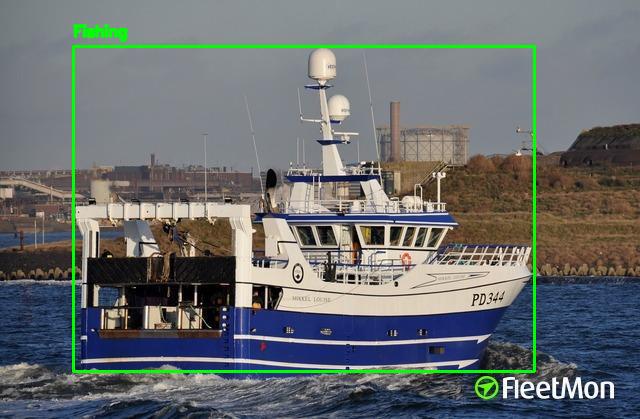

In [ ]:
# Dicionário de classes
CLASSES_NAVIOS = {0: "Fishing",
           1: "Merchant",
           2: "Military",
           3: "Patrol",
           4: "Sailboat",
           5: "Submarine",
           6: "Yacht",
           7: "Tug"}

def load_yolo_annotations(label_path, img_width, img_height):

    boxes = []

    if not os.path.exists(label_path):
        print(f"Arquivo de anotação não encontrado: {label_path}")
        return []

    with open(label_path, "r") as f:
        lines = f.readlines()

        for line in lines:
            data = line.strip().split()
            class_id = int(data[0])
            x_center, y_center, width, height = map(float, data[1:])

            # Converte coordenadas normalizadas (0 a 1) para pixel
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            # Calcula bounding box (x_min, y_min, x_max, y_max)
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)

            boxes.append((class_id, x_min, y_min, x_max, y_max))

    return boxes


def draw_bounding_boxes(image_path, label_path):
    # Carregar imagem
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erro ao carregar imagem: {image_path}")
        #return

    img_height, img_width = image.shape[:2]

    # Carregar anotações
    boxes = load_yolo_annotations(label_path, img_width, img_height)

    # Desenhar bounding boxes
    for (class_id, x_min, y_min, x_max, y_max) in boxes:
        color = (0, 255, 0)  # Cor verde para as bounding boxes
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)

        label = CLASSES_NAVIOS.get(class_id, f"Classe {class_id}")
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color, 2, cv2.LINE_AA)

    # Exibir imagem com bounding boxes
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Exemplo de uso
image_path = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/train/images/fish_10_jpg.rf.345244c4f93125f81e67396b8e7cc204.jpg"
label_path = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/train/labels/fish_10_jpg.rf.345244c4f93125f81e67396b8e7cc204.txt"

draw_bounding_boxes(image_path, label_path)

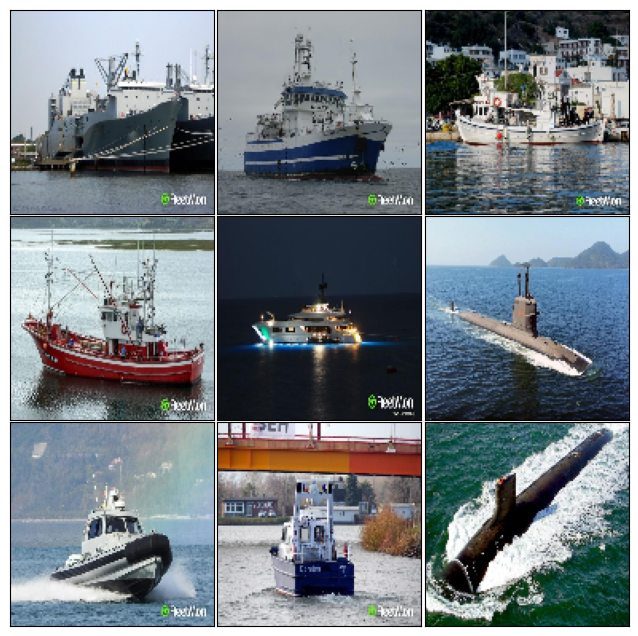

In [ ]:
# Exemplo de imagens do dataset

# Defina o caminho para o diretório das imagens
dataset_path = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/train/images"

# Lista todas as imagens disponíveis no diretório
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Define o número de imagens a serem exibidas (máximo de 64)
num_images = min(16, len(image_files))
selected_images = np.random.choice(image_files, num_images, replace=False)

# Tamanho desejado para cada imagem no grid (por exemplo, 128x128 pixels)
img_size = 128

# Criando a figura e os eixos
fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Ajuste do tamanho da figura
plt.subplots_adjust(wspace=0.01, hspace=0.01)  # Reduz o espaço entre as imagens

# Itera sobre as imagens e exibe na grid
for ax, img_name in zip(axes.flatten(), selected_images):
    img_path = os.path.join(dataset_path, img_name)
    img = cv2.imread(img_path)  # Carrega a imagem
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converte para RGB

    # Redimensiona a imagem para ser quadrada
    img = cv2.resize(img, (img_size, img_size))

    ax.imshow(img)
    ax.set_xticks([])  # Remove os ticks do eixo X
    ax.set_yticks([])  # Remove os ticks do eixo Y

plt.show()

## 1.2 - Binarizações

### 1.2.1 - Código Termômetro simples

In [ ]:
class ThermometerEncoder(object):
    def __init__(self, minimum, maximum, resolution):
        self.minimum = minimum
        self.maximum = maximum
        self.resolution = resolution

    def __repr__(self):
        return f"ThermometerEncoder(minimum={self.minimum}, maximum={self.maximum}, resolution={self.resolution})"

    def encode(self, X):
        X = np.asarray(X)

        if X.ndim == 0:
            f = lambda i: X > self.minimum + i*(self.maximum - self.minimum)/self.resolution
        elif X.ndim == 1:
            f = lambda i, j: X[j] > self.minimum + i*(self.maximum - self.minimum)/self.resolution
        else:
            f = lambda i, j, k: X[k, j] > self.minimum + i*(self.maximum - self.minimum)/self.resolution
        return  np.fromfunction(
            f,
            (self.resolution, *reversed(X.shape)),
            dtype=int
        ).astype(int)

    def decode(self, pattern):
        pattern = np.asarray(pattern)

        # TODO: Check if pattern is at least a vector
        # TODO: Check if pattern length or number of rows is equal to resolution
        # TODO: Check if pattern is a binary array
        if pattern.ndim == 1:
            # TODO: Test np.count_nonzero
            popcount = np.sum(pattern)

            return self.minimum + popcount*(self.maximum - self.minimum)/self.resolution

        return np.asarray([self.decode(pattern[...,i]) for i in range(pattern.shape[-1])])

# 2 - Treinamento das Redes

## 2.0 - Backbone MobileNetV3 p/ Extração de Features

In [ ]:
import cv2
import numpy as np

def add_padding(image_path, target_size=224):

    # Carregar a imagem
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    if img is None:
        raise ValueError(f"Erro ao carregar a imagem: {image_path}")

    # Obter dimensões da imagem original
    h, w, _ = img.shape

    # Determinar a nova dimensão quadrada
    max_dim = max(h, w)

    # Criar um fundo branco (ou preto, se preferir usar np.zeros)
    padded_img = np.zeros((max_dim, max_dim, 3), dtype=np.uint8)

    # Calcular deslocamento para centralizar a imagem no fundo quadrado
    x_offset = (max_dim - w) // 2
    y_offset = (max_dim - h) // 2

    # Inserir a imagem original dentro do fundo quadrado
    padded_img[y_offset:y_offset + h, x_offset:x_offset + w] = img

    # Redimensionar para o tamanho desejado
    img_resized = cv2.resize(padded_img, (target_size, target_size), interpolation=cv2.INTER_AREA)

    # POR ENQUANTO RETORNANDO A IMAGEM ORIGINAL E NÃO COM PADDING
    return img

In [ ]:
# Carregar o modelo MobileNetV3 Small pré-treinado
mobilenet = models.mobilenet_v3_small(pretrained=True)

# Remover a última camada de classificação (ficamos só com o backbone)
backbone = torch.nn.Sequential(*list(mobilenet.children())[:-1])  # Remove FC layer

# Configurar para modo de avaliação
backbone.eval()

# Função para extrair e normalizar features de uma imagem
def extract_features(image_path):
    # Definir as transformações da imagem (redimensionamento, normalização, etc.)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Tamanho padrão do MobileNetV3
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização do ImageNet
    ])

    # Converter imagem NumPy para PIL
    #image = Image.fromarray(cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB))

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    # Passar pela MobileNetV3 para extrair features
    with torch.no_grad():
        features = backbone(image_tensor)

    # Flatten do tensor para um vetor
    feature_vector = features.view(-1).cpu().numpy()

    # Valores mínimo e máximo fixos para normalização (Rodei em todas as pastas e procurei pelo 5 e 95 quartis)
    fixed_min = -0.13
    fixed_max = 1.37

    # Normalizar o vetor de features para o intervalo [0, 1]
    normalized_features = (feature_vector - fixed_min) / (fixed_max - fixed_min)
    normalized_features = np.clip(normalized_features, 0, 1) # Clipa entre 0 e 1
    normalized_features = np.round(normalized_features, 4)  # Arredonda para 2 casas decimais

    thermometer = ThermometerEncoder(minimum=0, maximum=1, resolution=20)
    encoded_features = thermometer.encode(normalized_features)

    return encoded_features.flatten()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 41.7MB/s]


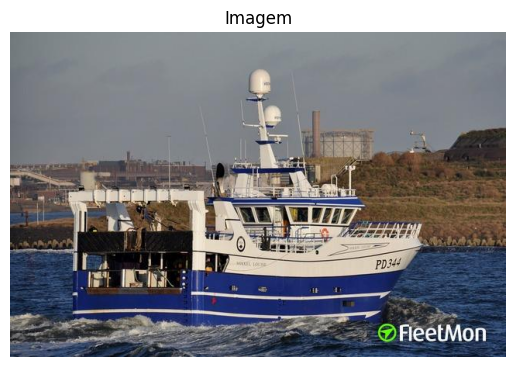

Feature vector (normalized): 
 [1 1 1 ... 0 0 0]


In [ ]:
# Exemplo de uso
image_path = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/train/images/fish_10_jpg.rf.345244c4f93125f81e67396b8e7cc204.jpg"
padded_image = add_padding(image_path)

import matplotlib.pyplot as plt

# Converter imagem e exibir
padded_img_rgb = cv2.cvtColor(padded_image, cv2.COLOR_BGR2RGB)
plt.imshow(padded_img_rgb)
plt.axis("off")
plt.title("Imagem")
plt.show()

features = extract_features(image_path)
print("Feature vector (normalized): \n", features)

### Código para verificar a extensão dos valores da MobileNet e definir range de normalização nos 5 e 95 quartis

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models

# Caminho da pasta com as imagens
image_folder = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images"

# Carregar o modelo MobileNetV3 pré-treinado
mobilenet = models.mobilenet_v3_small(pretrained=True)

# Remover a última camada de classificação (ficamos só com o backbone)
backbone = torch.nn.Sequential(*list(mobilenet.children())[:-1])
backbone.eval()

# Transformação da imagem
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Inicializar lista para armazenar uma amostra das features
sample_features = []

# Processar todas as imagens na pasta
for i, filename in enumerate(os.listdir(image_folder)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Verifica extensões de imagem
        image_path = os.path.join(image_folder, filename)

        # Carregar e processar a imagem
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0)

        # Extrair features
        with torch.no_grad():
            features = backbone(image)

        # Flatten do tensor para um vetor
        feature_vector = features.view(-1).cpu().numpy()

        # Adicionar apenas uma pequena amostra das features para evitar uso excessivo de memória
        sample_features.extend(np.random.choice(feature_vector, size=min(100, len(feature_vector)), replace=False))

        # Limitar a quantidade de amostras para evitar consumo excessivo de memória
        if len(sample_features) > 10000:  # Exemplo: armazenar no máximo 10.000 valores
            break

# Converter para array numpy para cálculo dos percentis
sample_features = np.array(sample_features)

# Calcular os percentis de 5% e 95%
percentile_min = np.percentile(sample_features, 5)
percentile_max = np.percentile(sample_features, 95)

# Imprimir os valores de percentil mínimo e máximo entre todas as imagens
print(f"Percentil 5% (mínimo): {percentile_min}")
print(f"Percentil 95% (máximo): {percentile_max}")


Percentil 5% (mínimo): -0.12736807763576508
Percentil 95% (máximo): 1.3369796693325005


## 2.1 - WiSARD

### 2.2.1 - Treino WiSARD

In [ ]:
# Início Medição

trackerC = EmissionsTracker(project_name="Model_C")  # Nome da tarefa
preprocessTimeStart = time.time()
trackerC.start()

# Diretório base
train_dir = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/train/images"
test_dir = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images"
valid_dir = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/valid/images"


# Criar um mapeamento de classes automaticamente a partir dos nomes dos arquivos
def get_class_mapping(directory):
    class_names = set()
    for filename in os.listdir(directory):
        if "_" in filename and filename.endswith((".jpg", ".png")):
            class_name = filename.split("_")[0]  # Obtém o prefixo antes do underline
            class_names.add(class_name)
    return {class_name: idx for idx, class_name in enumerate(sorted(class_names))}

# Criar um mapeamento de classes a partir do diretório de treinamento
class_mapping = get_class_mapping(train_dir)

def load_data_from_folder(image_folder, class_mapping, batch_size=16):

    binary_data = []
    labels = []

    # Listando todos os arquivos na pasta
    image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png"))]

    for img_name in tqdm(image_files, desc="Processando Imagens", unit="img"):
        # Construindo caminho completo
        img_path = os.path.join(image_folder, img_name)

        # padded_image = add_padding(img_path)
        features = extract_features(img_path)

        # Adicionar ao vetor de treino
        binary_data.append(features)

        # Obter rótulo da classe a partir do nome do arquivo
        class_name = img_name.split("_")[0]  # Obtém o prefixo antes do "_"
        label = class_mapping[class_name]  # Converte para índice numérico
        labels.append(label)

    # Converter listas para numpy arrays
    binary_data = np.array(binary_data)
    labels = np.array(labels)

    return binary_data, labels


# Mapear classes para texto
class_mapping = get_class_mapping(train_dir)
print("Classes:", class_mapping)

# Carregando os dados com barras de progresso
print("Carregando e binarizando os dados de treinamento...")
train_data, train_labels = load_data_from_folder(train_dir, class_mapping)

print("Carregando e binarizando os dados de validação...")
valid_data, valid_labels = load_data_from_folder(valid_dir, class_mapping)

print("Carregando e binarizando os dados de teste...")
test_data, test_labels = load_data_from_folder(test_dir, class_mapping)

trackerC.stop()
preprocessTimeStop = time.time()


### 2.2.2 - Teste e Avaliação

In [ ]:
%%time

import wisardpkg as wp

# Converter para lista para montar wp.Dataset
train_data_new = train_data.astype(int).tolist()
train_labels_new = train_labels.astype(str).tolist()
address_size = 16  # Tamanho tupla WiSARD

trainingTimeStart = time.time()
trackerC.start()
# Criar o DataSet da WiSARD
dataset = wp.DataSet(train_data_new, train_labels_new)

# Criando e treinando o modelo WiSARD
print("Treinando o modelo WiSARD...")


model = wp.Wisard(address_size)
model.train(dataset)

trackerC.stop()
trainingTimeStop = time.time()

In [ ]:
from sklearn.metrics import classification_report

# DATASET DE VALIDAÇÃO ( Ajustar tuple size por aqui )

# Converter para lista para montar wp.Dataset
valid_data_list = valid_data.astype(int).tolist()
valid_labels_list = valid_labels.astype(str).tolist()

# Fazer predição com a WiSARD
valid_dataset = wp.DataSet(valid_data_list)
predicted_labels = model.classify(valid_dataset)

# Criar o relatório de classificação
report = classification_report(valid_labels_list, predicted_labels, target_names=class_mapping.keys())

# Exibir relatório
print(report)


In [ ]:

# Converter para lista para montar wp.Dataset
test_data_list = test_data.astype(int).tolist()
test_labels_list = test_labels.astype(str).tolist()

inferenceTimeStart = time.time()
trackerC.start()

# Fazer predição com a WiSARD
test_dataset = wp.DataSet(test_data_list)
predicted_labels = model.classify(test_dataset)

trackerC.stop()
inferenceTimeStop = time.time()

# Criar o relatório de classificação
report = classification_report(test_labels_list, predicted_labels, target_names=class_mapping.keys())

# Exibir relatório

print(report)

[codecarbon WARNING @ 05:09:29] Already started tracking
[codecarbon WARNING @ 05:09:29] Tracker already stopped !
[codecarbon INFO @ 05:09:29] Energy consumed for RAM : 0.000100 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 05:09:29] Energy consumed for all CPUs : 0.000895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:09:29] Energy consumed for all GPUs : 0.000197 kWh. Total GPU Power : 9.353114463285888 W
[codecarbon INFO @ 05:09:29] 0.001192 kWh of electricity used since the beginning.


              precision    recall  f1-score   support

        fish       0.88      0.88      0.88         8
       merch       1.00      1.00      1.00         6
    military       0.82      1.00      0.90         9
      patrol       0.90      1.00      0.95         9
       sails       1.00      0.89      0.94        18
         sub       1.00      1.00      1.00        11
       yacht       1.00      0.89      0.94         9

    accuracy                           0.94        70
   macro avg       0.94      0.95      0.94        70
weighted avg       0.95      0.94      0.94        70



## 2.2 - Regression WiSARD

### 2.2.1 - Treino Regression WiSARD

In [ ]:
# ============================================
# Hiperparâmetros
# ============================================
IMG_SIZE = 224
GRID_SIZE = 14
STRIDE = IMG_SIZE // GRID_SIZE  # Nosso caso 224 / 14 = 16
NUM_CLASSES = 7
ANCHORS = torch.tensor([
    [16. / IMG_SIZE, 16. / IMG_SIZE],  # anchor 1
    [14. / IMG_SIZE, 32. / IMG_SIZE],  # anchor 2
    [32. / IMG_SIZE, 14. / IMG_SIZE]   # anchor 3
])  # Testar diferentes tamanhos com 1:1, 1:2 e 2:1 ratios

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def encode_gt(Bx, By, Bw, Bh, grid_size, img_size, anchors):
    """
    - Bx, By: Coordenadas absolutas do centro do bounding box.
    - Bw, Bh: Largura e altura absolutas do bounding box.

    - tx, ty, tw, th: Coordenadas relativas para treinar as WiSARDs.
    - cx, cy: Índices da célula da grade responsável.
    """
    stride = img_size / grid_size  # Tamanho de cada célula na imagem

    #print('Bx:', Bx)
    #print('By:', By)

    # Descobrindo em qual célula da grade o centro do bounding box está
    cx = int(Bx * grid_size)
    cy = int(By * grid_size)

    #print('cx:', cx)
    #print('cy:', cy)

    # Ajustando tx, ty para serem deslocamentos relativos dentro da célula
    tx = (Bx * grid_size) - cx
    ty = (By * grid_size) - cy

    #print('tx:', tx)
    #print('ty:', ty)

    # Ajustando largura e altura usando os anchors
    diff_w = torch.abs(anchors[:, 0] - Bw) / anchors[:, 0]
    diff_h = torch.abs(anchors[:, 1] - Bh) / anchors[:, 1]
    score = diff_w + diff_h

    # Índice do melhor anchor
    best_anchor = torch.argmin(score)
    best_anchor = 1 ###### Ancora fixa por enquanto

    anchor_w, anchor_h = anchors[best_anchor - 1]

    tw = torch.log((Bw / (anchor_w )) + 1e-6)
    th = torch.log((Bh / (anchor_h )) + 1e-6)

    #print('tw:', tw)
    #print('th:', th)

    return tx, ty, tw, th, cx, cy, best_anchor

In [ ]:
trackerR = EmissionsTracker(project_name="Model_R")  # Nome da tarefa
preprocessRegressionTimeStart = time.time()
trackerR.start()

# Diretório base
train_dir = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/train/"
images_dir_train = f"{train_dir}/images"
labels_dir_train = f"{train_dir}/labels"

valid_dir = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/valid/"
images_dir_valid = f"{valid_dir}/images"
labels_dir_valid = f"{valid_dir}/labels"

test_dir = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/"
images_dir_test = f"{test_dir}/images"
labels_dir_test = f"{test_dir}/labels"

def load_data_from_folder_rew(image_folder, labels_folder):
    binary_data = []
    labels_x = []
    labels_y = []
    labels_w = []
    labels_h = []

    # Listando todas as imagens na pasta
    image_files = [f for f in os.listdir(image_folder) if f.endswith((".jpg", ".png"))]

    for img_name in tqdm(image_files, desc="Processando Imagens", unit="img"):
        # Construindo caminho completo para a imagem
        img_path = os.path.join(image_folder, img_name)

        # Construindo caminho do arquivo de anotação correspondente
        label_filename = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(labels_folder, label_filename)

        if not os.path.exists(label_path):
            print(f"Aviso: Anotação não encontrada para {img_name}, pulando.")
            continue

        # Lendo a anotação YOLO
        with open(label_path, "r") as file:
            lines = file.readlines()

        if len(lines) == 0:
            print(f"Aviso: Arquivo de anotação {label_filename} está vazio, pulando.")
            continue

        # Processar a primeira anotação da linha (YOLO usa várias anotações por arquivo)
        first_annotation = lines[0].strip().split()

        # Extrair features e binarizar (chama sua função já implementada)
        thermometer = ThermometerEncoder(minimum=0, maximum=1, resolution=20)

        #padded_image = add_padding(img_path)
        features = extract_features(img_path)

        Bx, By, Bw, Bh = map(float, first_annotation[1:])  # Pegando as coordenadas YOLO

        labels_x.append(Bx)
        labels_y.append(By)
        labels_w.append(Bw)
        labels_h.append(Bh)

        binary_data.append(list(features)) # Usar esse se quiser testar em informacoes da bbox


    return binary_data, labels_x, labels_y, labels_w, labels_h


# Carregando os dados com barras de progresso
print("Carregando e binarizando os dados de treinamento...")
train_data, train_label_x, train_label_y, train_label_w, train_label_h = load_data_from_folder_rew(images_dir_train, labels_dir_train)

print("Carregando e binarizando os dados de treinamento...")
valid_data, valid_label_x, valid_label_y, valid_label_w, valid_label_h = load_data_from_folder_rew(images_dir_valid, labels_dir_valid)

print("Carregando e binarizando os dados de teste...")
test_data, test_label_x, test_label_y, test_label_w, test_label_h = load_data_from_folder_rew(images_dir_test, labels_dir_test)

trackerR.stop()
preprocessRegressionTimeStop = time.time()

[codecarbon INFO @ 05:09:34] [setup] RAM Tracking...
[codecarbon INFO @ 05:09:34] [setup] CPU Tracking...
[codecarbon WARNING @ 05:09:34] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 05:09:36] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 05:09:36] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 05:09:36] [setup] GPU Tracking...
[codecarbon INFO @ 05:09:36] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 05:09:36] >>> Tracker's metadata:
[codecarbon INFO @ 05:09:36]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 05:09:36]   Python version: 3.11.11
[codecarbon INFO @ 05:09:36]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 05:09:36]   Available RAM : 12.675 GB
[codecarbon INFO @ 05:09:36]   CPU count: 2
[codeca

Carregando e binarizando os dados de treinamento...


Processando Imagens:   6%|▋         | 38/592 [00:14<03:51,  2.39img/s][codecarbon INFO @ 05:09:51] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 05:09:51] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:09:51] Energy consumed for all GPUs : 0.000039 kWh. Total GPU Power : 9.315514801511803 W
[codecarbon INFO @ 05:09:51] 0.000236 kWh of electricity used since the beginning.
Processando Imagens:  14%|█▎        | 81/592 [00:29<02:54,  2.92img/s][codecarbon INFO @ 05:10:06] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 05:10:06] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:10:06] Energy consumed for all GPUs : 0.000078 kWh. Total GPU Power : 9.306986511548917 W
[codecarbon INFO @ 05:10:06] 0.000471 kWh of electricity used since the beginning.
Processando Imagens:  20%|██        | 119/592 [00:44<03:03,  2.58img

Carregando e binarizando os dados de treinamento...


Processando Imagens:  51%|█████▏    | 18/35 [00:06<00:05,  3.02img/s][codecarbon INFO @ 05:13:21] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 05:13:21] Energy consumed for all CPUs : 0.002655 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:13:21] Energy consumed for all GPUs : 0.000578 kWh. Total GPU Power : 9.220865347189848 W
[codecarbon INFO @ 05:13:21] 0.003530 kWh of electricity used since the beginning.
Processando Imagens: 100%|██████████| 35/35 [00:12<00:00,  2.78img/s]


Carregando e binarizando os dados de teste...


Processando Imagens:  33%|███▎      | 23/70 [00:09<00:20,  2.33img/s][codecarbon INFO @ 05:13:36] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 05:13:36] Energy consumed for all CPUs : 0.002832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:13:36] Energy consumed for all GPUs : 0.000616 kWh. Total GPU Power : 9.203890159942885 W
[codecarbon INFO @ 05:13:36] 0.003766 kWh of electricity used since the beginning.
[codecarbon INFO @ 05:13:36] 0.005476 g.CO2eq/s mean an estimation of 172.6961919535952 kg.CO2eq/year
Processando Imagens:  93%|█████████▎| 65/70 [00:24<00:01,  3.34img/s][codecarbon INFO @ 05:13:51] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 05:13:51] Energy consumed for all CPUs : 0.003009 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:13:51] Energy consumed for all GPUs : 0.000655 kWh. Total GPU Power : 9.188204829652014 W
[codecarbon INFO @ 05:13:51] 0.004001 kWh of electr

In [ ]:
%time
trackerR.start()
trainingRegressionTimeStart = time.time()

address_size = 32  # Tamanho tupla WiSARD

#Coordenada X
model_rew_x = wp.RegressionWisard(address_size)
dataset_x = wp.DataSet(train_data, train_label_x)
model_rew_x.train(dataset_x)

#Coordenada Y
model_rew_y = wp.RegressionWisard(address_size)
dataset_y = wp.DataSet(train_data, train_label_y)
model_rew_y.train(dataset_y)

#Coordenada W
model_rew_w = wp.RegressionWisard(address_size)
dataset_w = wp.DataSet(train_data, train_label_w)
model_rew_w.train(dataset_w)


#Coordenada H
model_rew_h = wp.RegressionWisard(address_size)
dataset_h = wp.DataSet(train_data, train_label_h)
model_rew_h.train(dataset_h)

trackerR.stop()
trainingRegressionTimeStop = time.time()

[codecarbon WARNING @ 05:13:57] Already started tracking


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.82 µs


[codecarbon WARNING @ 05:14:02] Tracker already stopped !
[codecarbon INFO @ 05:14:02] Energy consumed for RAM : 0.000352 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 05:14:02] Energy consumed for all CPUs : 0.003145 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 05:14:02] Energy consumed for all GPUs : 0.000684 kWh. Total GPU Power : 9.26528456417664 W
[codecarbon INFO @ 05:14:02] 0.004181 kWh of electricity used since the beginning.


### 2.2.2 - Testes e Avaliação

0.49606719451167786 0.4832911318857209 0.7382031249999998 0.6948748159050887
['0']


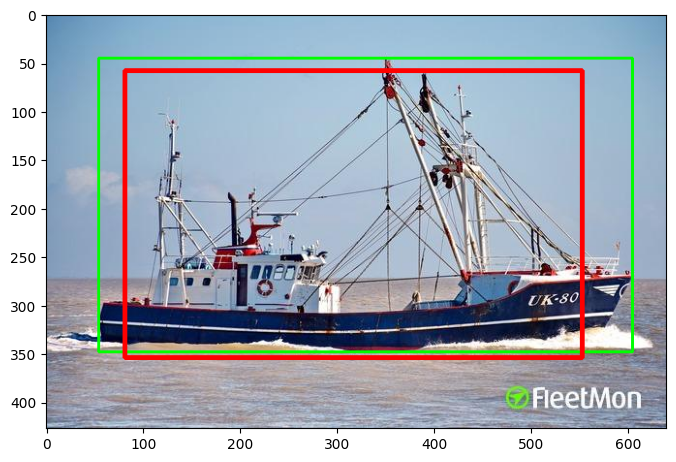

In [ ]:
## Visualização de uma imagem

def visualize_prediction(image_path, labels_folder):
    # Carregar imagem
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if image is None:
        print(f"Erro: Não foi possível carregar a imagem {image_path}")
        return

    bin_features = [] # Garantir que está no formato correto

    # Extrair features da nova imagem e converter para binário
    features = extract_features(image_path)

    # Binarizando cx,cy e best anchor com termômetros
    thermometer_centro = ThermometerEncoder(minimum=0, maximum=13, resolution=56)
    cx_bin = thermometer_centro.encode(13)
    cy_bin = thermometer_centro.encode(13)

    thermometer_anchor = ThermometerEncoder(minimum=0, maximum=2, resolution=3)
    best_anchor_bin = thermometer_anchor.encode(1)

    bbox_info = list(cx_bin) + list(cy_bin) + list(best_anchor_bin)

    #bin_features.append(list(features) + list(bbox_info))
    bin_features.append(list(features)) #

    # Criar um dataset com uma única entrada
    dataset_pred = wp.DataSet(bin_features)  # Formato aceito pela biblioteca

    # Fazer predição corretamente
    pred_tx = model_rew_x.predict(dataset_pred)
    pred_ty = model_rew_y.predict(dataset_pred)
    pred_tw = model_rew_w.predict(dataset_pred)
    pred_th = model_rew_h.predict(dataset_pred)

    bx, by, bw, bh = pred_tx[0], pred_ty[0], pred_tw[0], pred_th[0]

    # Converter coordenadas normalizadas YOLO para coordenadas de pixels
    img_height, img_width, _ = image.shape

    box_x = int(bx * img_width)  # Centro da bounding box em pixels (x)
    box_y = int(by * img_height)  # Centro da bounding box em pixels (y)
    box_w = int(bw * img_width)  # Largura da bounding box em pixels
    box_h = int(bh * img_height)  # Altura da bounding box em pixels

    # Calcular coordenadas do retângulo (esquina superior esquerda e inferior direita)
    x1_pred = int(box_x - box_w / 2)
    y1_pred = int(box_y - box_h / 2)
    x2_pred = int(box_x + box_w / 2)
    y2_pred = int(box_y + box_h / 2)

    # Ler anotação real da pasta labels
    label_filename = os.path.splitext(os.path.basename(image_path))[0] + ".txt"
    label_path = os.path.join(labels_folder, label_filename)

    if os.path.exists(label_path):
        with open(label_path, "r") as file:
            lines = file.readlines()
        if len(lines) > 0:
            first_annotation = lines[0].strip().split()
            true_x, true_y, true_w, true_h = map(float, first_annotation[1:])
            tx, ty, tw, th, cx, cy, best_anchor = encode_gt(true_x, true_y, true_w, true_h, GRID_SIZE, IMG_SIZE, ANCHORS)

            # Converter para coordenadas em pixels
            box_x_real = int(true_x * img_width)
            box_y_real = int(true_y * img_height)
            box_w_real = int(true_w * img_width)
            box_h_real = int(true_h * img_height)

            # Calcular bounding box real
            x1_real = int(box_x_real - box_w_real / 2)
            y1_real = int(box_y_real - box_h_real / 2)
            x2_real = int(box_x_real + box_w_real / 2)
            y2_real = int(box_y_real + box_h_real / 2)

            # Desenhar bounding box real em verde
            cv2.rectangle(image, (x1_real, y1_real), (x2_real, y2_real), (0, 255, 0), 2)  # Verde = ground truth
        else:
            print(f"Aviso: Arquivo de anotação {label_filename} está vazio.")
    else:
        print(f"Aviso: Anotação não encontrada para {label_filename}")

    # Desenhar bounding box predita em azul
    cv2.rectangle(image, (x1_pred, y1_pred), (x2_pred, y2_pred), (255, 0, 0), 4)  # Azul = predição

    # Classificação do modelo WiSARD (corrigindo a chamada)
    try:
        class_pred = model.classify(dataset_pred)  # Modelo correto de classificação
        print(class_pred)
        label = CLASSES_NAVIOS.get(class_pred, f"Classe {class_pred}")
    except Exception as e:
        label = f"Erro na classificação: {e}"

    # Exibir a imagem com bounding box
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.show()
    print()

# Caminho da imagem de teste e labels
image_path = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/fish_18_jpg.rf.8e9e789954d70447316e87a19e85234d.jpg"
labels_folder = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/labels/"

# Visualizar predição com comparação real
visualize_prediction(image_path, labels_folder)

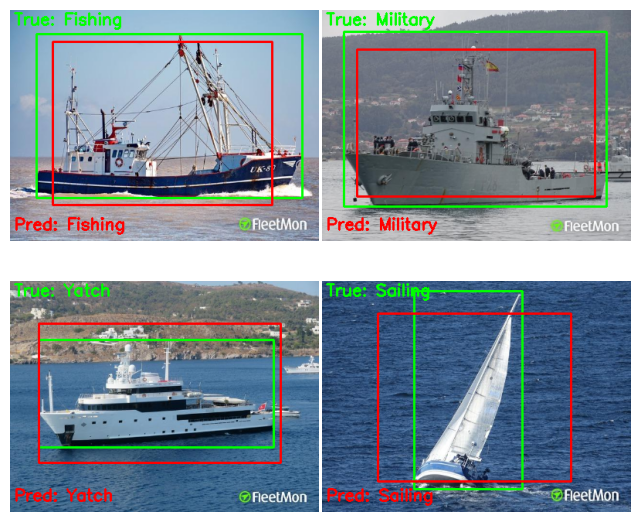

In [ ]:
# Definir tamanho fixo para as imagens (ex: 400x300 pixels)
IMG_WIDTH = 400
IMG_HEIGHT = 300

def visualize_prediction(image_paths, labels_folder):
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))
    axes = axes.flatten()

    for idx, image_path in enumerate(image_paths):
        if idx >= 4:  # Limitar a 4 imagens
            break

        # Carregar imagem
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is None:
            print(f"Erro: Não foi possível carregar a imagem {image_path}")
            continue

        # Redimensionar todas as imagens para o mesmo tamanho
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

        bin_features = []

        # Extrair features da imagem
        features = extract_features(image_path)
        bin_features.append(list(features))

        # Criar dataset para predição
        dataset_pred = wp.DataSet(bin_features)

        # Fazer predição com WiSARD
        pred_tx = model_rew_x.predict(dataset_pred)
        pred_ty = model_rew_y.predict(dataset_pred)
        pred_tw = model_rew_w.predict(dataset_pred)
        pred_th = model_rew_h.predict(dataset_pred)

        # Conversão dos valores para bounding box
        bx, by, bw, bh = pred_tx[0], pred_ty[0], pred_tw[0], pred_th[0]
        img_height, img_width, _ = image.shape

        # Converter coordenadas normalizadas para pixels
        box_x = int(bx * img_width)
        box_y = int(by * img_height)
        box_w = int(bw * img_width)
        box_h = int(bh * img_height)

        # Calcular bounding box predita
        x1_pred = int(box_x - box_w / 2)
        y1_pred = int(box_y - box_h / 2)
        x2_pred = int(box_x + box_w / 2)
        y2_pred = int(box_y + box_h / 2)

        # Ler anotação real
        label_filename = os.path.splitext(os.path.basename(image_path))[0] + ".txt"
        label_path = os.path.join(labels_folder, label_filename)

        true_label = "Unknown"
        if os.path.exists(label_path):
            with open(label_path, "r") as file:
                lines = file.readlines()
            if len(lines) > 0:
                first_annotation = lines[0].strip().split()
                true_x, true_y, true_w, true_h = map(float, first_annotation[1:])

                # Converter para pixels
                box_x_real = int(true_x * img_width)
                box_y_real = int(true_y * img_height)
                box_w_real = int(true_w * img_width)
                box_h_real = int(true_h * img_height)

                # Calcular bounding box real
                x1_real = int(box_x_real - box_w_real / 2)
                y1_real = int(box_y_real - box_h_real / 2)
                x2_real = int(box_x_real + box_w_real / 2)
                y2_real = int(box_y_real + box_h_real / 2)

                # Nome da classe real
                class_id = int(first_annotation[0])  # ID da classe no dataset
                true_label = CLASSES_NAVIOS.get(class_id, f"Class {class_id}")

                # Desenhar bounding box real em verde
                cv2.rectangle(image, (x1_real, y1_real), (x2_real, y2_real), (0, 255, 0), 2)  # Verde

        # Desenhar bounding box predita em azul
        cv2.rectangle(image, (x1_pred, y1_pred), (x2_pred, y2_pred), (255, 0, 0), 2)  # Azul

        # Classificação do modelo WiSARD
        try:
            class_pred = model.classify(dataset_pred)
            pred_label = CLASSES_NAVIOS.get(int(class_pred[0]), f"Class {class_pred}")
        except Exception as e:
            pred_label = f"Error: {e}"

        # Escrever labels na imagem
        cv2.putText(image, f"True: {true_label}", (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)  # Verde
        cv2.putText(image, f"Pred: {pred_label}", (5, 285), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)  # Vermelho

        # Exibir na grid 2x2
        axes[idx].imshow(image)
        axes[idx].axis("off")

    # Ajustar layout para remover espaços em branco
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    plt.show()

# Lista de imagens para exibição
image_paths = [
    "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/fish_18_jpg.rf.8e9e789954d70447316e87a19e85234d.jpg",
    "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/military_64_jpg.rf.f152238f998b23bebd1d072354d230fa.jpg",
    "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/yacht_73_jpg.rf.422d480a56f0ce4ee72f1de3ee038f1c.jpg",
    "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/sails_58_jpg.rf.0f7bdc0bdd116ccc0961fc610d9ec362.jpg"
]

# Visualizar predições em grid 2x2
visualize_prediction(image_paths, "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/labels/")


In [ ]:
inferenceRegressionTimeStart = time.time()
trackerR.start()

def calculate_absolute_error(pred, gt):
    """ Calcula o erro absoluto entre valores previstos e ground truth """
    return abs(pred[0] - gt)

def visualize_predictions(images_folder, labels_folder):
    # Listar todas as imagens na pasta
    image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

    erros_x = []
    erros_y = []
    erros_w = []
    erros_h = []

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(images_folder, image_file)

        # Carregar imagem
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is None:
            print(f"Erro: Não foi possível carregar a imagem {image_path}")
            continue

        bin_features = []  # Garantir que está no formato correto

        # Extrair features da nova imagem
        features = extract_features(image_path)

        # Criar um dataset com uma única entrada
        bin_features.append(list(features))
        dataset_pred = wp.DataSet(bin_features)  # Formato aceito pela biblioteca

        # Fazer predição corretamente
        pred_tx = model_rew_x.predict(dataset_pred)
        pred_ty = model_rew_y.predict(dataset_pred)
        pred_tw = model_rew_w.predict(dataset_pred)
        pred_th = model_rew_h.predict(dataset_pred)

# Caminhos das pastas de imagens e labels
images_folder = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/"
labels_folder = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/labels/"

# Rodar a avaliação em todas as imagens
visualize_predictions(images_folder, labels_folder)

trackerR.stop()
inferenceRegressionTimeStop = time.time()

[codecarbon WARNING @ 02:15:24] Already started tracking
[codecarbon WARNING @ 02:15:26] Tracker already stopped !
[codecarbon INFO @ 02:15:26] Energy consumed for RAM : 0.000295 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 02:15:26] Energy consumed for all CPUs : 0.002641 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:15:26] Energy consumed for all GPUs : 0.000584 kWh. Total GPU Power : 9.332313452973251 W
[codecarbon INFO @ 02:15:26] 0.003520 kWh of electricity used since the beginning.
[codecarbon INFO @ 02:15:26] 0.002180 g.CO2eq/s mean an estimation of 68.75425368486528 kg.CO2eq/year


## 2.3 - Código YOLOv8 e comparação

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.1/949.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
from ultralytics import YOLO
from sklearn.metrics import classification_report, mean_squared_error
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:

trackerY = EmissionsTracker(project_name='YOLOv8')

trainingYOLOTimeStart = time.time()
trackerY.start()

!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/data.yaml epochs=100 imgsz=640 batch=16

trackerY.stop()
trainingYOLOTimeStop = time.time()

In [ ]:
from ultralytics import YOLO
import torch
from codecarbon import EmissionsTracker

# Carregar modelo YOLO treinado
model = YOLO("/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/yolo8s_SeaVesselDataset.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import time

# Executar validação no conjunto de teste
#results_val = model.val(data="/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/data.yaml", split="test")

trackerYX = EmissionsTracker(project_name='Inf YOLOV8')
inferenceYOLOTimeStart = time.time()
trackerYX.start()

results = model.predict(source="/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/", save=False)

trackerYX.stop()
inferenceYOLOTimeStop = time.time()

[codecarbon INFO @ 02:27:42] [setup] RAM Tracking...
[codecarbon INFO @ 02:27:42] [setup] CPU Tracking...
[codecarbon WARNING @ 02:27:42] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 02:27:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 02:27:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 02:27:43] [setup] GPU Tracking...
[codecarbon INFO @ 02:27:43] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:27:43] >>> Tracker's metadata:
[codecarbon INFO @ 02:27:43]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 02:27:43]   Python version: 3.11.11
[codecarbon INFO @ 02:27:43]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 02:27:43]   Available RAM : 12.675 GB
[codecarbon INFO @ 02:27:43]   CPU count: 2
[codeca


image 1/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/fish_18_jpg.rf.8e9e789954d70447316e87a19e85234d.jpg: 448x640 1 Fishing Boat, 39.6ms
image 2/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/fish_19_jpg.rf.d725336998be242dcb6f68912f3c0fd7.jpg: 480x640 1 Fishing Boat, 40.4ms
image 3/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/fish_1_jpg.rf.0f35d44a4ca16245d97f6f5651d0d071.jpg: 480x640 1 Military Ship, 13.2ms
image 4/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/fish_4_jpg.rf.fc6fa4d94df11bc88a96650bc455d529.jpg: 448x640 1 Fishing Boat, 13.8ms
image 5/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/fish_52_jpg.rf.cf4fd4e2614f71d9ecc32aaa0693debf.jpg: 480x640 1 Fishing Boat, 14.0ms
image 6/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/fish_55_jpg.rf.e73c986772025798e2d4ca7f66623351.jpg: 416x640 1 Fishing Boat, 40.2ms
image 7/70 /content/drive/MyDrive/datasets/Sea

[codecarbon INFO @ 02:27:58] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 02:27:58] Energy consumed for all CPUs : 0.000178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:27:58] Energy consumed for all GPUs : 0.000104 kWh. Total GPU Power : 24.73719866762533 W
[codecarbon INFO @ 02:27:58] 0.000302 kWh of electricity used since the beginning.


image 14/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/merch_8_jpg.rf.ad663b4fe35ab933596a8202c78e36f8.jpg: 448x640 1 Merchant Ship, 13.1ms
image 15/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/military_19_jpg.rf.55274a4fb9bb2ac83e88c3eb17aab4bd.jpg: 448x640 1 Military Ship, 13.0ms
image 16/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/military_1_jpg.rf.567c03578439d277cd6bab222ee56f1c.jpg: 480x640 1 Military Ship, 13.9ms
image 17/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/military_27_jpg.rf.f03daa8d5409f7f3c0376b92bb204e50.jpg: 448x640 1 Military Ship, 13.8ms
image 18/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/military_43_jpg.rf.80256d5b194c007723b1ffb9705a3cef.jpg: 448x640 1 Military Ship, 13.5ms
image 19/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/military_51_jpg.rf.5127e69d0f16d76e2fd90a82616cd4ea.jpg: 448x640 1 Military Ship, 13.1ms
image 20/70 /co

[codecarbon INFO @ 02:28:13] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 02:28:13] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:13] Energy consumed for all GPUs : 0.000211 kWh. Total GPU Power : 25.760738353578063 W
[codecarbon INFO @ 02:28:13] 0.000606 kWh of electricity used since the beginning.


image 44/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/sails_66_jpg.rf.008602381162ea1e16d56df262c9021e.jpg: 448x640 1 Sails Boat, 14.1ms
image 45/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/sails_69_jpg.rf.499ddc8738e7b7b470a4018ba685233d.jpg: 416x640 1 Sails Boat, 13.8ms
image 46/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/sails_6_jpg.rf.541e2ccddd9c179c935638fac26d654a.jpg: 384x640 1 Sails Boat, 66.9ms
image 47/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/sails_72_jpg.rf.b41ca91159a9f455121646a6a8aa2a0a.jpg: 640x480 1 Sails Boat, 12.9ms
image 48/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/sails_73_jpg.rf.3ca56022c6e377aac819c3a3496cc811.jpg: 640x480 2 Sails Boats, 12.1ms
image 49/70 /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/sails_78_jpg.rf.ec6af9dfbe16bf6cf606a4e05c4fd9f6.jpg: 640x448 1 Sails Boat, 12.6ms
image 50/70 /content/drive/MyDrive/datasets/Se

[codecarbon INFO @ 02:28:26] Energy consumed for RAM : 0.000056 kWh. RAM Power : 4.753036022186279 W
[codecarbon INFO @ 02:28:26] Energy consumed for all CPUs : 0.000504 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 02:28:26] Energy consumed for all GPUs : 0.000301 kWh. Total GPU Power : 25.748305669878594 W
[codecarbon INFO @ 02:28:26] 0.000862 kWh of electricity used since the beginning.
/usr/local/lib/python3.11/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


### 2.3.1 Calculando o tempo em todas as etapas

In [ ]:


#trainingYOLOTime = trainingYOLOTimeStop - trainingYOLOTimeStart
inferenceYOLOTime = inferenceYOLOTimeStop - inferenceYOLOTimeStart


#print(f"Training YOLO Time: {trainingYOLOTime:.4f} seconds")
print(f"Inference YOLO Time: {inferenceYOLOTime:.4f} seconds")

Inference YOLO Time: 42.7629 seconds


In [ ]:
preprocessTime = preprocessTimeStop - preprocessTimeStart
trainingTime = trainingTimeStop - trainingTimeStart
inferenceTime = inferenceTimeStop - inferenceTimeStart

preprocessRegressionTime = preprocessRegressionTimeStop - preprocessRegressionTimeStart
trainingRegressionTime = trainingRegressionTimeStop - trainingRegressionTimeStart
inferenceRegressionTime = inferenceRegressionTimeStop - inferenceRegressionTimeStart

print(f"Preprocess Classification Time: {preprocessTime:.6f} seconds")
print(f"Training Classification Time: {trainingTime:.6f} seconds")
print(f"Inference Classification Time: {inferenceTime:.6f} seconds")

print(f"Preprocess Regression Time: {preprocessRegressionTime:.6f} seconds")
print(f"Training Regression Time: {trainingRegressionTime:.6f} seconds")
print(f"Inference Regression Time: {inferenceRegressionTime:.6f} seconds")

Preprocess Classification Time: 50.678426 seconds
Training Classification Time: 0.666239 seconds
Inference Classification Time: 0.496668 seconds
Preprocess Regression Time: 199.480004 seconds
Training Regression Time: 6.009943 seconds
Inference Regression Time: 1.859164 seconds


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

def calculate_absolute_error(pred, gt):
    """ Calcula o erro absoluto entre valores previstos e ground truth """
    return abs(pred - gt)

def visualize_predictions(images_folder, labels_folder, results):
    # Listar todas as imagens na pasta
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))])

    erros_x = []
    erros_y = []
    erros_w = []
    erros_h = []

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(images_folder, image_file)

        # Carregar imagem
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is None:
            print(f"Erro: Não foi possível carregar a imagem {image_path}")
            continue

        # Verificar se há predições para essa imagem
        if len(results[i].boxes.xywhn) == 0:
            print(f"Aviso: Nenhuma predição encontrada para {image_file}")
            continue

        # Ler anotação real (Ground Truth)
        label_filename = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_folder, label_filename)

        if not os.path.exists(label_path):
            print(f"Aviso: Anotação não encontrada para {label_filename}")
            continue

        with open(label_path, "r") as file:
            lines = file.readlines()

        if len(lines) == 0:
            print(f"Aviso: Arquivo de anotação vazio para {label_filename}")
            continue

        # Pegando a primeira anotação do arquivo
        first_annotation = lines[0].strip().split()
        true_x, true_y, true_w, true_h = map(float, first_annotation[1:])

        # Comparar todas as bounding boxes preditas e selecionar a melhor
        min_erro_total = float('inf')
        best_bx, best_by, best_bw, best_bh = None, None, None, None

        for pred_box in results[i].boxes.xywhn:
            bx, by, bw, bh = pred_box.tolist()

            # Calcular erro absoluto (MAE) entre predição e ground truth
            erro_x = calculate_absolute_error(bx, true_x)
            erro_y = calculate_absolute_error(by, true_y)
            erro_w = calculate_absolute_error(bw, true_w)
            erro_h = calculate_absolute_error(bh, true_h)

            erro_total = erro_x + erro_y + erro_w + erro_h  # Soma dos erros

            # Se esta é a melhor predição até agora, armazena os valores
            if erro_total < min_erro_total:
                min_erro_total = erro_total
                best_bx, best_by, best_bw, best_bh = bx, by, bw, bh

        # Se encontra alguma BB, adiciona o erro calculado ao vetor (evitar append none)
        if best_bx is not None:
            erros_x.append(calculate_absolute_error(best_bx, true_x))
            erros_y.append(calculate_absolute_error(best_by, true_y))
            erros_w.append(calculate_absolute_error(best_bw, true_w))
            erros_h.append(calculate_absolute_error(best_bh, true_h))

            print(f"Imagem {i + 1} -> Erro x: {erros_x[-1]:.4f}, Erro y: {erros_y[-1]:.4f}, Erro w: {erros_w[-1]:.4f}, Erro h: {erros_h[-1]:.4f}")

    # Exibir estatísticas finais se houver valores
    if erros_x:
        print("\n=== Médias Finais YOLO ===")
        print(f"MAE x: {np.mean(erros_x):.4f}")
        print(f"MAE y: {np.mean(erros_y):.4f}")
        print(f"MAE w: {np.mean(erros_w):.4f}")
        print(f"MAE h: {np.mean(erros_h):.4f}")
    else:
        print("Nenhum erro foi calculado. Verifique as predições e anotações.")

# Caminhos das pastas de imagens e labels
images_folder = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/images/"
labels_folder = "/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/labels/"

# Rodar a avaliação em todas as imagens
visualize_predictions(images_folder, labels_folder, results)

Imagem 1 -> Erro x: 0.0039, Erro y: 0.0006, Erro w: 0.0099, Erro h: 0.0085
Imagem 2 -> Erro x: 0.0023, Erro y: 0.0024, Erro w: 0.0038, Erro h: 0.0016
Imagem 3 -> Erro x: 0.0045, Erro y: 0.0061, Erro w: 0.0057, Erro h: 0.0022
Imagem 4 -> Erro x: 0.0026, Erro y: 0.0105, Erro w: 0.0046, Erro h: 0.0209
Imagem 5 -> Erro x: 0.0050, Erro y: 0.0073, Erro w: 0.0118, Erro h: 0.0092
Imagem 6 -> Erro x: 0.0008, Erro y: 0.0023, Erro w: 0.0062, Erro h: 0.0128
Imagem 7 -> Erro x: 0.0018, Erro y: 0.0075, Erro w: 0.0058, Erro h: 0.0402
Imagem 8 -> Erro x: 0.0017, Erro y: 0.0154, Erro w: 0.0001, Erro h: 0.0336
Imagem 9 -> Erro x: 0.0006, Erro y: 0.0020, Erro w: 0.0036, Erro h: 0.0105
Imagem 10 -> Erro x: 0.0013, Erro y: 0.0164, Erro w: 0.0281, Erro h: 0.0263
Imagem 11 -> Erro x: 0.0032, Erro y: 0.0036, Erro w: 0.0059, Erro h: 0.0152
Imagem 12 -> Erro x: 0.0016, Erro y: 0.0045, Erro w: 0.0123, Erro h: 0.0121
Imagem 13 -> Erro x: 0.0144, Erro y: 0.0097, Erro w: 0.0332, Erro h: 0.0034
Imagem 14 -> Erro x: 

In [ ]:
# Avaliação no conjunto de teste (mode=val, split=test)
!yolo task=detect mode=val model=/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/yolo8s_SeaVesselDataset.pt data=/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/data.yaml split=test

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100% 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:16<00:00,  3.29s/it]
                   all         70         70      0.883      0.976      0.981      0.858
          Fishing Boat          8          8      0.702      0.883      0.946       0.88
         Merchant Ship          6          6      0.922          1      0.995      0.961
         Military Ship          9          9      0.899          1      0.973      0.793
           Patrol Boat          9          9       0.86          1      0.984      0.825
            Sails Boat         18         18       0.91          1      0.989        0.9
             Submarine       

In [ ]:
# Treino YOLO (mode=train)

# !yolo task=classify mode=train model=yolov8s-cls.pt data=/content/drive/MyDrive/datasets/ships_simpleCNN epochs=50 imgsz=640

In [ ]:
# Avaliação no conjunto de teste (mode=val, split=test)
!yolo task=detect mode=val model=/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/yolo8s_SeaVesselDataset.pt data=/content/drive/MyDrive/datasets/Sea_Vessels_Dataset/data.yaml split=test

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 11,128,293 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /content/drive/MyDrive/datasets/Sea_Vessels_Dataset/test/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100% 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:12<00:00,  2.52s/it]
                   all         70         70      0.883      0.976      0.981      0.858
          Fishing Boat          8          8      0.702      0.883      0.946       0.88
         Merchant Ship          6          6      0.922          1      0.995      0.961
         Military Ship          9          9      0.899          1      0.973      0.793
           Patrol Boat          9          9       0.86          1      0.984      0.825
            Sails Boat         18         18       0.91          1      0.989        0.9
             Submarine       